<a href="https://colab.research.google.com/github/stivenbg/Basics_ML/blob/main/Deepoonets_biais_aware_DA_orthogonal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import torch
import numpy as np
import scipy.io as io
import os
import matplotlib.pyplot as plt
import time
import scipy.io as io
import sys
import matplotlib.gridspec as gridspec
import torch.nn.init as init


In [15]:
sys.path.insert(0, 'Utilities/')
import os

# from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

np.random.seed(42)
import sys
import torch.nn as nn
import torch.optim as optim

In [16]:
data2 = io.loadmat('/content/train_501_mu2_pod1')
datatest = io.loadmat('/content/test_501_mu2_pod1_v2.mat')

In [17]:
#Data
# %% ici le train cest le test, normalement ca devrait bien fonctionner ensutie je change le test
#u_train, v_train, x_train, y_train, u_test, v_test = data2['utrain'].T, data2['vtrain'].T, data2['xtrain'], data2['ytrain'], data2['utest'].T, data2['vtest'].T
u_train, v_train, x_train, y_train = data2['utrain'].T, data2['vtrain'].T, data2['xtrain'], data2['ytrain']

# %%
#u_train = np.reshape(u_train, (101, 40))
#u_train.shape
# %%
#v_train = v_train * 5
v_train.shape
# %%
x_train.shape
# %%
y_train.shape
# %%
x_y_train = np.hstack([x_train, y_train])
# %%
x_y_train = x_y_train
# %%
x_y_train.shape
# %%
u_test = datatest['utest']
u_test = u_test.T
u_test.shape
#%%
#u_test = u_train
u_test.shape

# %%
#v_test = v_train

v_test = datatest['vtest']
v_test = v_test.T
v_test.shape

# #%% test on non scaled data
# v2 = data2['vtest']
# v2 = v_test.T
# #v_test = v_test * 5
# v2.shape
#%%

#x_test, y_test = x_train, y_train
#%%
#x_test.shape
#y_test.shape

# %%
x_test = datatest['xtest']
x_test.shape
 # %%
y_test = datatest['ytest']
y_test.shape
# %%
x_y_test = np.hstack([x_test, y_test])
x_y_test.shape
#%%
x_y_test.shape

(40, 2)

In [18]:
#modele


class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()

    # Initialization for DNNs
    def hyper_initial(self, layers):
        L = len(layers)
        W = []
        b = []
        for l in range(1, L):
            in_dim = layers[l - 1]
            out_dim = layers[l]
            std = np.sqrt(2.0 / (in_dim + out_dim))
            weight = nn.Parameter(torch.randn(in_dim, out_dim) * std)
            bias = nn.Parameter(torch.randn(1, out_dim) * std)
            W.append(weight)
            b.append(bias)
        return W, b

    def fnn_B(self, X, W, b):
        A = X
        L = len(W)
        for i in range(L - 1):
            A = torch.tanh(torch.matmul(A, W[i]) + b[i])
        Y = torch.matmul(A, W[-1]) + b[-1]
        return Y

    def fnn_T(self, X, W, b):
        A = X
        L = len(W)
        for i in range(L - 1):
            A = torch.tanh(torch.matmul(A, W[i]) + b[i])
        Y = torch.matmul(A, W[-1]) + b[-1]
        return Y


u_dim = 40

# Output dimension for Branch and Trunk Net
G_dim = 40

# Branch Net
layers_f = [u_dim] + [40] * 2 + [G_dim]

# Trunk dim
x_dim = 2

# Trunk Net
layers_x = [x_dim] + [40] * 2 + [G_dim]

model = DNN()

In [19]:
B_values = [-0.3459, -0.7421, -0.3391, -0.8532, -0.3048, -0.4194, -0.2397, -0.7632, -0.7112, -0.4430, -0.3836, -0.9075, -0.9155, -0.5346, -0.3763, -0.4993, -0.3200, -0.4221, -0.3184, -0.3640, -0.5890, -0.2932, -0.6207, -0.4214, -0.4484, -0.7744, -0.3246, -0.8052, -0.3483, -0.3869, -0.8546, -0.3238, -0.2879, -0.9148, -0.8857, -0.8965, -0.6248, -0.3008, -0.5907, -0.3535]

#B = np.array(B_values,dtype=np.float32).reshape(40, 1)
B = torch.from_numpy(np.array(B_values, dtype=np.float32).reshape(40, 1))


In [39]:
B_tensor = torch.tensor(B)

B_values = [-0.3459, -0.7421, -0.3391, -0.8532, -0.3048, -0.4194, -0.2397, -0.7632,
    -0.7112, -0.4430, -0.3836, -0.9075, -0.9155, -0.5346, -0.3763, -0.4993,
    -0.3200, -0.4221, -0.3184, -0.3640, -0.5890, -0.2932, -0.6207, -0.4214,
    -0.4484, -0.7744, -0.3246, -0.8052, -0.3483, -0.3869, -0.8546, -0.3238,
    -0.2879, -0.9148, -0.8857, -0.8965, -0.6248, -0.3008, -0.5907, -0.3535]

B = np.array(B_values).reshape(40, 1)


In [20]:
## introducing the differential equations
def f_net(model, x, v, W_branch, b_branch, W_trunk, b_trunk):
    mu = 2
    epsilon = 0.01

    u_out_branch = model.fnn_B(v, W_branch, b_branch)
    u_out_trunk = model.fnn_T(x, W_trunk, b_trunk)
    # u_pred = torch.einsum('ij,jj->ij', u_out_branch, u_out_trunk)
    u_pred = torch.einsum('ij,kj->ik', u_out_branch, u_out_trunk)

    u_x = torch.autograd.grad(u_pred.sum(), x[:, 0], create_graph=True)
    u_y = torch.autograd.grad(u_pred, x[:, 1])
    u_xx = torch.autograd.grad(u_x, x[:, 0])
    u_yy = torch.autograd.grad(u_y, x[:, 1])

    laplacian = u_xx + u_yy
    res_loss = np.sqrt(1 + (epsilon * mu) ** 2) * laplacian - mu ** 2 * u_pred - mu**2 * v


def train_step(model, W_branch, b_branch, W_trunk, b_trunk, v, x, u, optimizer):
    train_vars = W_branch + b_branch + W_trunk + b_trunk
    optimizer.zero_grad()
    u_out_branch = model.fnn_B(v, W_branch, b_branch)
    u_out_trunk = model.fnn_T(x, W_trunk, b_trunk)
    # u_pred = torch.einsum('ij,jj->ij', u_out_branch, u_out_trunk)
    u_pred = torch.einsum('ij,kj->ik', u_out_branch, u_out_trunk)

    mu = 2
    epsilon = 0.01

    inputs = torch.ones(40, 1) # faire attention à cette ligne parce qu'elle definit la dimension de l'input. A chaque fois qu'on change la dimn  de l'input changer la dim ici
    u_1 = u_pred
    #     u_1 = u_1.reshape(-1, 1)
    residual = 0.0
     #for i in range(len(u_pred)):
        # u1 = u_pred[i, :]
         # = u1.T
         #u1 = u1.reshape(-1, 1)

        #grad_u = torch.autograd.grad(u1, x, grad_outputs=inputs, create_graph=True)[0]
         #u_x = grad_u[:, 0].reshape(-1, 1)

         #u_y = grad_u[:, 1].reshape(-1, 1)

         #grad_u_x = torch.autograd.grad(u_x, x, grad_outputs=inputs, create_graph=True)[0]
         #u_xx = grad_u_x[:, 0].reshape(-1, 1)

         #grad_u_y = torch.autograd.grad(u_y, x, grad_outputs=inputs, create_graph=True)[0]
         #u_yy = grad_u_y[:, 1].reshape(-1, 1)

        # v1 = v.T
        # v1 = v1[:, i].reshape(-1, 1)

         #laplacian = u_xx + u_yy
         #res_loss = - np.sqrt(1 + (epsilon * mu) ** 2) * laplacian.reshape(-1, ) - mu ** 2 * u1.reshape(
         #    -1, ) - v1.reshape(-1, )  ##pde loss ici dans v y'a deja mu donc on eleve mu devant
         #residual += res_loss
    #         residual.append(res_loss)

    #     x1 = x[:,0]
    #     x1 = x1.reshape((-1,1))
    #     expanded_x = x1.expand(-1, 100)

    #     y1 = x[:,1]
    #     y1 = y1.reshape((-1,1))
    #     expanded_y = y1.expand(-1, 100)

    #     grad_u_hat = torch.autograd.grad(u_1, expanded_x, grad_outputs=inputs, create_graph=True, allow_unused=True)[0]
    #     u_x = grad_u_hat

    #     u_y = torch.autograd.grad(u_1, expanded_y, grad_outputs=inputs, create_graph=True, allow_unused=True)[0]

    # #     u_y = grad_u_hat[:, 1].reshape(-1,1)

    #     u_xx = torch.autograd.grad(u_x, expanded_x, grad_outputs=inputs, create_graph=True, allow_unused=True)[0]

    #     u_yy = torch.autograd.grad(u_y, expanded_y, grad_outputs=inputs, create_graph=True, allow_unused=True)[0]

    # #     grad_u_x = torch.autograd.grad(u_x, x, grad_outputs=inputs, create_graph=True)[0]
    # #     u_xx = grad_u_x[:, 0].reshape(-1,1)

    # #     grad_u_y = torch.autograd.grad(u_y, x, grad_outputs=inputs, create_graph=True)[0]
    # #     u_yy = grad_u_y[:, 1].reshape(-1,1)

    #     v_1 = v.T
    # #     v_1 = v_1[:, 0].reshape(-1, 1)

    #     laplacian = u_xx+u_yy
    #     res_loss = np.sqrt(1+(epsilon*mu)**2)*laplacian.reshape(-1,)-mu**2*u_1.reshape(-1,)-mu*v_1.reshape(-1,)  ##pde loss

    #     residual = f_net(model, x, v, W_branch, b_branch, W_trunk, b_trunk)

    #     residual = np.array(residual, dtype = np.float32)
    #     residual = residual.reshape(-1,1)
    #loss_pde = torch.mean(torch.abs(residual)) #utiliser abs c'est MAE, plutôt que square pour mse
    data_loss = torch.mean(torch.square(u_pred - u))
    #ortho = np.dot(u_pred[-1,:], B)
    loss_ortho = torch.mean(torch.matmul(u_pred[-1,:], B))


    #loss = data_loss + 0.00005*loss_pde
    #loss = loss_pde
    #loss = data_loss + ortho


    loss = torch.mean(torch.square(u_pred - u)) + 0.001*torch.abs(loss_ortho)
    loss.backward()
    optimizer.step()
    return loss.item(), u_pred.detach(), loss_ortho.item(), data_loss.item()
    #return loss.item(), u_pred.detach(), data_loss.item()



def test_step(model, W_branch, b_branch, W_trunk, b_trunk, v, x, u, optimizer):
    x_test_tensor = torch.from_numpy(x).float()
    v_test_tensor = torch.from_numpy(v).float()
    u_test_tensor = torch.from_numpy(u).float()

    with torch.no_grad():
        u_out_branch = model.fnn_B(v_test_tensor, W_branch, b_branch)
        u_out_trunk = model.fnn_T(x_test_tensor, W_trunk, b_trunk)
        # u_pred = torch.einsum('ij,jj->ij', u_out_branch, u_out_trunk)
        u_pred = torch.einsum('ij,kj->ik', u_out_branch, u_out_trunk)

        loss = torch.mean(torch.square(u_pred - u_test_tensor))

    return loss.item(), u_pred.detach().numpy()

In [21]:
#Initialisation
W_branch, b_branch = model.hyper_initial(layers_f)
W_trunk, b_trunk = model.hyper_initial(layers_x)

In [13]:

from torch.optim.lr_scheduler import ReduceLROnPlateau

n = 0
nmax = 10000
lr = 1e-4
start_time = time.perf_counter()
time_step_0 = time.perf_counter()
l2_reg_strength = 1e-5  # You can adjust this value

optimizer = optim.Adam(list(W_branch) + list(b_branch) + list(W_trunk) + list(b_trunk), lr=lr,  weight_decay=l2_reg_strength)
scheduler = ReduceLROnPlateau(optimizer=optimizer)

data_loss_list = []
loss_ortho_list = []
train_err_list = []
test_err_list = []
train_loss_list = []
test_loss_list = []

try:
    while n <= nmax:
        x_train_tensor = torch.from_numpy(x_y_train).float()
        x_train_tensor.requires_grad_(True)
        v_train_tensor = torch.from_numpy(v_train).float()
        u_train_tensor = torch.from_numpy(u_train).float()

        loss_train, u_train_pred, loss_ortho, data_loss = train_step(model, W_branch, b_branch, W_trunk,
                                              b_trunk, v_train_tensor, x_train_tensor, u_train_tensor,
                                              optimizer)
        #loss_train, u_train_pred, data_loss = train_step(model, W_branch, b_branch, W_trunk,
                                              #b_trunk, v_train_tensor, x_train_tensor, u_train_tensor,
                                              #optimizer)




        #     #err_train = np.mean(np.linalg.norm(u_train - u_train_pred, 2, axis=1) /
        #                         np.linalg.norm(u_train, 2, axis=1))

        u_train_pred_np = u_train_pred.detach().numpy()

        err_train = np.mean(np.linalg.norm(u_train - u_train_pred_np, 2, axis=1) /
                            np.linalg.norm(u_train, 2, axis=1))

        loss_test, u_test_pred = test_step(model, W_branch, b_branch, W_trunk, b_trunk, v_test, x_y_test, u_test,
                                           optimizer)
        err_test = np.mean(np.linalg.norm(u_test - u_test_pred, 2, axis=1) /
                           np.linalg.norm(u_test, 2, axis=1))

        if n % 200 == 0:
            print(f"Iteration: {n} Train_loss:{loss_train}, Test_loss: {loss_test}")
            print(f"Iteration: {n} Train_loss:{loss_train}, ortho_loss:{torch.abs(loss_ortho)}")

        train_err_list.append(err_train)
        test_err_list.append(err_test)
        train_loss_list.append(loss_train)
        test_loss_list.append(loss_test)
        loss_ortho_list.append(loss_ortho)
        data_loss_list.append(data_loss)

        if n % 1000 == 0:
            gs = gridspec.GridSpec(1, 1)
            ax = plt.subplot(gs[:, :])
            plt.semilogy(range(len(train_loss_list)), train_loss_list, 'b-', label='Train Loss')
            plt.semilogy(range(len(test_loss_list)), test_loss_list, 'r--', label='Test Loss')
            plt.semilogy(range(len(loss_ortho_list)), torch.abs(loss_ortho), 'g-.', label='Ortho Loss')


            #plt.plot(range(len(train_loss_list)), train_loss_list, 'b-', label='Train Loss')
            #plt.plot(range(len(test_loss_list)), test_loss_list, 'r--', label='Test Loss')
            #plt.semilogy(range(len(pde_loss_list)), pde_loss_list, 'g-.', label='PDE_t Loss')
            #plt.semilogy(range(len(data_loss_list)), data_loss_list, 'm:', label='Data_t loss')

            plt.xlabel('Iterations')
            plt.ylabel('Loss (log scale)')

            # Set the y-axis ticks and labels using a logarithmic scale
            yticks = [ 10 ** -5, 10 ** -4, 10 ** -3, 10 ** -2, 10 ** -1, 10 ** 0]
            yticklabels = [ '1e-5', '1e-4', '1e-3', '0.01', '0.1', '1']
            plt.yticks(yticks, yticklabels)
            # Set the y-axis limits
            ax.set_ylim([10 ** -5, 1])

            plt.legend()
            plt.show()


        n = n + 1

except KeyboardInterrupt:
    print("Training interrupted. Saving the model...")

# Save the model
#torch.save(model.state_dict(), 'model_deeponet.pth')

Iteration: 0 Train_loss:0.00142373563721776, Test_loss: 0.0037415465340018272


TypeError: ignored

<function matplotlib.pyplot.show(close=None, block=None)>

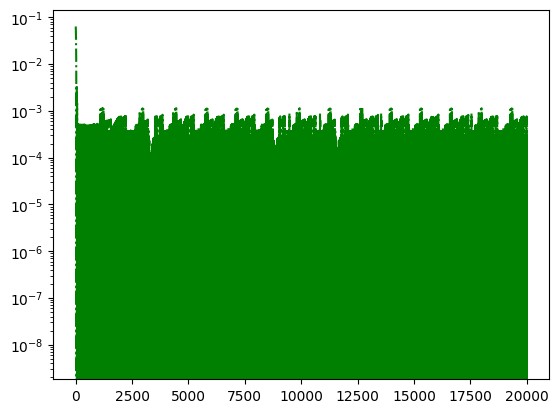

In [81]:
plt.semilogy(range(len(loss_ortho_list)), loss_ortho_list, 'g-.', label='Ortho Loss')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

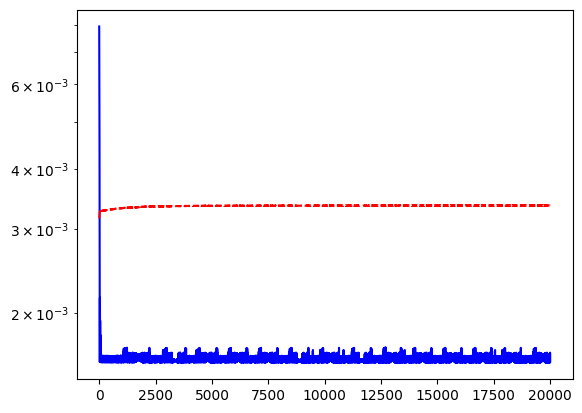

In [82]:
ax = plt.subplot(gs[:, :])
plt.semilogy(range(len(train_loss_list)), train_loss_list, 'b-', label='Train Loss')
plt.semilogy(range(len(test_loss_list)), test_loss_list, 'r--', label='Test Loss')
plt.show

In [35]:
u_test_pred[-1, :]

array([ 0.2696401 ,  0.62413514,  0.54394245,  0.3172875 ,  0.08333118,
        0.03220244,  0.00322624,  0.5634373 ,  0.37163493,  0.50411284,
       -0.08667289,  0.59509224,  0.4762071 ,  0.04769747,  0.05797539,
        0.02530889,  0.22203866,  0.3697897 ,  0.32552275,  0.17498842,
        0.4034611 ,  0.0691569 ,  0.11030499,  0.22660951,  0.3053139 ,
        0.5038862 ,  0.13418874,  0.27199748,  0.43884912, -0.07108067,
        0.3431155 ,  0.10316935,  0.05411298,  0.574785  ,  0.60263795,
        0.49182573,  0.12576395,  0.06761909,  0.460396  ,  0.3199169 ],
      dtype=float32)

In [21]:
dot_products = np.dot(u_test_pred, B)
sum_of_dot_products = np.sum(dot_products)

In [83]:
torch.matmul(B, u_test_pred)

TypeError: ignored

In [22]:
print(sum_of_dot_products)

4480.7196612354255


In [87]:
for i in range(u_test_pred.shape[0]):
  dot_products = np.dot(u_test_pred[-1,:], B)
  print(dot_products )

[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.914847]
[-0.

[-0.914847]
